# CPSC 8810 Final Project: Deep Learning for Computational Photography

Before we start, please put your name and CUID in following format

: Firstname LASTNAME, #00000000   //   e.g.) Nianyi Li, #12345678

## Setup Code
Before getting started, we need to run some boilerplate code to set up our environment. You'll need to rerun this setup code each time you start the notebook.

First, run this cell load the autoreload extension. This allows us to edit .py source files, and re-import them into the notebook for a seamless editing and debugging experience.

In [1]:
%load_ext autoreload
%autoreload 2

### Google Colab Setup
Next we need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine you can skip this section.

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook!) and copy the authorization code into the text box that appears below.

In [2]:
# Running locally
# from google.colab import drive
# drive.mount('/content/drive')

# Data preprocessing

## Setup code
Import some useful packages and increase the default figure size.

In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import random

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

We will use GPUs to accelerate our computation in this notebook. Run the following to make sure GPUs are enabled:

In [4]:
device = torch.device("cpu")
if torch.cuda.is_available():
    print('Good to go!')
    device = torch.device("cuda")
else:
    print('Please set GPU via Edit -> Notebook Settings.')

Good to go!


# Load the dataset

Note: You need to create a dataloader to load the training and testing images. You may need to modify the data loader based on your own project's data types.

Please save your training data in a folder named "train", and testing/validation data in folder "val"

In [5]:
data_dir = 'dataset' # Replace with the path to your dataset
# image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}

# Gathered from https://pytorch.org/vision/stable/models.html
rgb_transforms = {
    'train': transforms.Compose([
        transforms.Resize((256,512)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406],
                             std=[0.229,0.224,0.225]),
    ]),
    'test': transforms.Compose([
        transforms.Resize((256,512)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406],
                             std=[0.229,0.224,0.225]),
    ]),
}

depth_transforms = {
    'train': transforms.Compose([
        transforms.Resize((256,512)),
        transforms.ToTensor(),    # outputs [1,H,W]
    ]),
    'test': transforms.Compose([
        transforms.Resize((256,512)),
        transforms.ToTensor(),
    ]),
}

class DepthDataset(Dataset):
    def __init__(self, root_dir, split,
                 rgb_transform=None, depth_transform=None):
        self.rgb_dir   = os.path.join(root_dir, split, 'images')
        self.depth_dir = os.path.join(root_dir, split, 'depths')
        # only keep the RGB files
        self.files     = sorted(f for f in os.listdir(self.rgb_dir)
                                if f.lower().endswith(('.jpg','.jpeg','.png')))
        self.rgb_transform   = rgb_transform
        self.depth_transform = depth_transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        fn = self.files[idx]
        # load RGB (.jpg or .png)
        img = Image.open(os.path.join(self.rgb_dir, fn)).convert('RGB')

        # swap extension to .png for the depth map
        base, _ = os.path.splitext(fn)
        depth_fn = base + '.png'
        depth_path = os.path.join(self.depth_dir, depth_fn)
        if not os.path.exists(depth_path):
            raise FileNotFoundError(f"Depth file not found: {depth_path}")
        depth = Image.open(depth_path)

        if self.rgb_transform:
            img   = self.rgb_transform(img)
        if self.depth_transform:
            depth = self.depth_transform(depth)

        return img, depth

batch_size = 8
num_workers = 1

image_datasets = {
    split: DepthDataset(
        root_dir = data_dir,
        split    = split,
        rgb_transform   = rgb_transforms[split],
        depth_transform = depth_transforms[split]
    )
    for split in ['train','test']
}

dataloaders = {
    split: DataLoader(
        image_datasets[split],
        batch_size=batch_size,
        shuffle=(split=='train'),
        num_workers=num_workers,
        pin_memory=True,
    )
    for split in ['train','test']
}

## Load the data
Note: This section loads the dataset from the specified directory. Replace 'path/to/dataset' with the actual path to your dataset. The ImageFolder class from torchvision is used to load the images and their corresponding labels.


This section creates data loaders for training and validation sets. The batch_size parameter determines the number of samples in each batch. The shuffle=True parameter ensures that the data is shuffled during training.


In [6]:
# Create data loaders
batch_size = 32
dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True) for x in ['train', 'test']}

## Visualize the loaded training and testing image pairs
Note: Print out a row a traing/validation data. Print out the input and output of the network:
- For Depth from 2D, please print out the input image and its corresponding depth map
- For PointCloud from 2D, please print out the input image and its corresponding point cloud. You may need to install PyTorch 3D for visualizing the point clould
- For NeRF, please print out the first batch input image of both Training and Testing

Training Data:


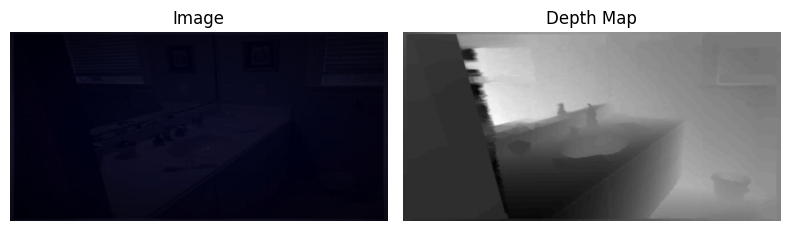

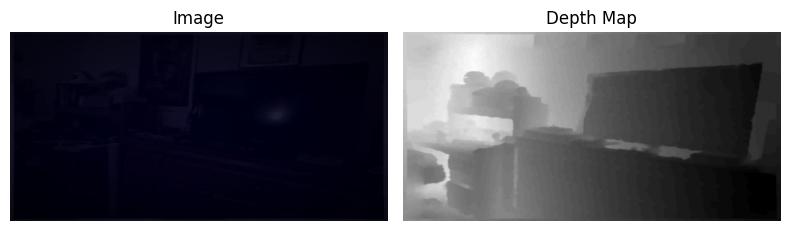

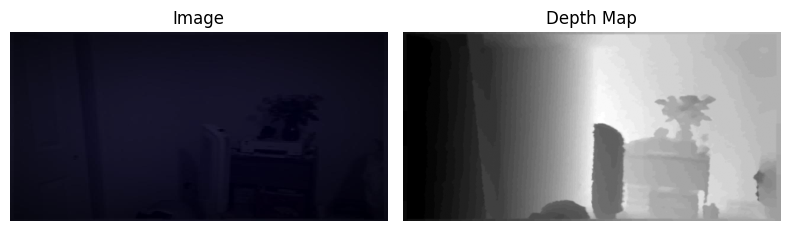


Validation Data:


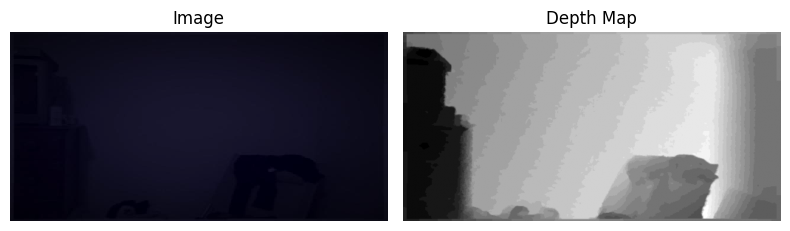

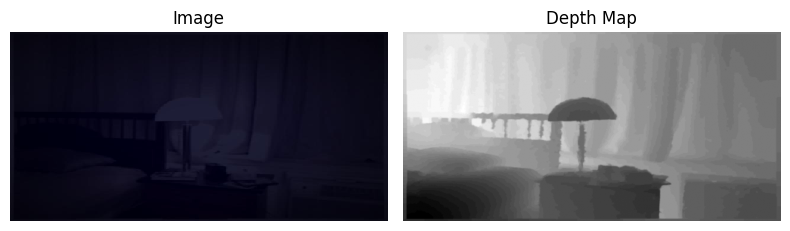

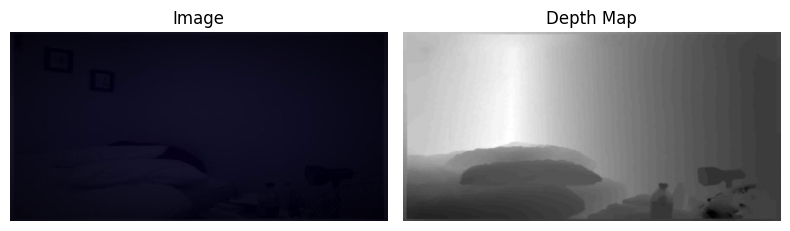

In [7]:
# Define your visulaization algorithm.
import matplotlib.pyplot as plt
def visualize_data(data_loader, num_images=1):
    # grab a single batch
    images, depths = next(iter(data_loader))           # images: [B,3,H,W], depths: [B,1,H,W]
    # un-normalize RGB
    mean = torch.tensor([0.485, 0.456, 0.406], device=images.device).view(1,3,1,1)
    std  = torch.tensor([0.229, 0.224, 0.225], device=images.device).view(1,3,1,1)
    images = images * std + mean

    for i in range(min(num_images, images.size(0))):
        img   = images[i].permute(1,2,0).cpu().numpy()
        depth = depths[i].squeeze(0).cpu().numpy()

        fig, (ax1,ax2) = plt.subplots(1,2, figsize=(8,4))
        ax1.imshow(img)
        ax1.set_title('Image')
        ax1.axis('off')

        ax2.imshow(depth, cmap='gray', interpolation="bilinear")
        ax2.set_title('Depth Map')
        ax2.axis('off')

        plt.tight_layout()
        plt.show()
        
# Print out a row of training/validation data and corresponding output images
print("Training Data:")  
visualize_data(dataloaders['train'], num_images=3)

print("\nValidation Data:")
visualize_data(dataloaders['test'], num_images=3)

# Define the Deep Learning model
Note: In this section, you need to define your own Deep Learning models for prediction

In [8]:
# Getting depth anything from transformers
from transformers import DepthAnythingConfig, DepthAnythingForDepthEstimation

def conv_block(in_ch, out_ch):
    return nn.Sequential(
        nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
    )

# Define the CNN model
class Real3DPredictionNN(nn.Module):
    ############## Insert your code below ##############
    def __init__(self, base_ch=32):
        super(Real3DPredictionNN, self).__init__()
        # Encoder
        self.enc1 = conv_block(3,       base_ch)      # [B,base,H, W]
        self.enc2 = conv_block(base_ch, base_ch*2)    # [B,2base,H/2,W/2]
        self.enc3 = conv_block(base_ch*2, base_ch*4)  # [B,4base,H/4,W/4]
        # Bottleneck
        self.bottleneck = conv_block(base_ch*4, base_ch*8)  # [B,8base,H/8,W/8]
        # Decoder convs (fuse after concat)
        self.dec3 = conv_block(base_ch*8 + base_ch*4, base_ch*4)  # [B,4base,H/4,W/4]
        self.dec2 = conv_block(base_ch*4 + base_ch*2, base_ch*2)  # [B,2base,H/2,W/2]
        self.dec1 = conv_block(base_ch*2 + base_ch,   base_ch)    # [B,base ,H,   W  ]
        # Final prediction
        self.final = nn.Conv2d(base_ch, 1, kernel_size=1)

        # single Upsample layer to reuse
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)

    def forward(self, x):
        # -- Encode
        c1 = self.enc1(x)
        p1 = F.max_pool2d(c1, 2)

        c2 = self.enc2(p1)
        p2 = F.max_pool2d(c2, 2)

        c3 = self.enc3(p2)
        p3 = F.max_pool2d(c3, 2)

        # -- Bottleneck
        b = self.bottleneck(p3)

        # -- Decode + Skip
        u3 = self.up(b)                       # [B,8base,H/4,W/4]
        u3 = torch.cat([u3, c3], dim=1)       # [B,8base+4base,H/4,W/4]
        c4 = self.dec3(u3)                    # [B,4base,H/4,W/4]

        u2 = self.up(c4)                      # [B,4base,H/2,W/2]
        u2 = torch.cat([u2, c2], dim=1)       # [B,4base+2base,H/2,W/2]
        c5 = self.dec2(u2)                    # [B,2base,H/2,W/2]

        u1 = self.up(c5)                      # [B,2base,H,W]
        u1 = torch.cat([u1, c1], dim=1)       # [B,2base+base,H,W]
        c6 = self.dec1(u1)                    # [B,base,H,W]

        return self.final(c6)                 # [B,1,H,W]
    
    
    
    
#     def __init__(self):
#         super(Real3DPredictionNN, self).__init__()
#         config = DepthAnythingConfig.from_pretrained("depth-anything/Depth-Anything-V2-Small-hf")
#         # DO NOT USE PRETRAINED WEIGHTS
#         config.use_pretrained_backbone = False
#         self.model = DepthAnythingForDepthEstimation(config)
    
#     def forward(self, pixel_values):
#         """
#         Args:
#           pixel_values: torch.Tensor [B,3,H,W], pre-normalized as per your rgb_transforms
#         Returns:
#           torch.Tensor [B,1,H,W]: predicted depth maps
#         """
#         outputs = self.model(pixel_values, return_dict=True)
#         # `predicted_depth` is [B, H, W]
#         depth = outputs.predicted_depth
#         return depth.unsqueeze(1)  # → [B,1,H,W]

    # return prediction_image
    ####################################################

/home/sgbecke/.conda/envs/8810/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Model Initialization
Note: This section initializes the model, loss function , and optimizer.

In [9]:
model = Real3DPredictionNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.00001)

# Verify no weights were preloaded
for name, p in model.named_parameters():
    print(name, p.flatten()[0:5])
    break

enc1.0.weight tensor([-0.0261, -0.0193, -0.1629, -0.0943,  0.1582], device='cuda:0',
       grad_fn=<SliceBackward0>)


## Loss Functions
Note: Please define the training loss

In [10]:
import torch.nn.functional as F

def Recons_loss(outputs, labels):
    ############## Insert your code below ##############

    # if outputs.shape[-2:] != labels.shape[-2:]:
    #     outputs = F.interpolate(
    #         outputs,
    #         size=labels.shape[-2:],
    #         mode='bilinear',
    #         align_corners=False
    #     )

    return F.l1_loss(outputs, labels)

    # loss_val = nn.L1Loss()
    # return loss_val(outputs, labels)
    ####################################################    

## Training Loop
Note: This section contains the training loop. It iterates over the specified number of epochs and trains the model on the training set. During the validation phase, it evaluates the model on the validation set without performing backpropagation and optimization. The loss for each epoch is calculated and printed.

Batch L1 loss before training:        0.1583
Single‐sample L1 loss before training: 0.2034


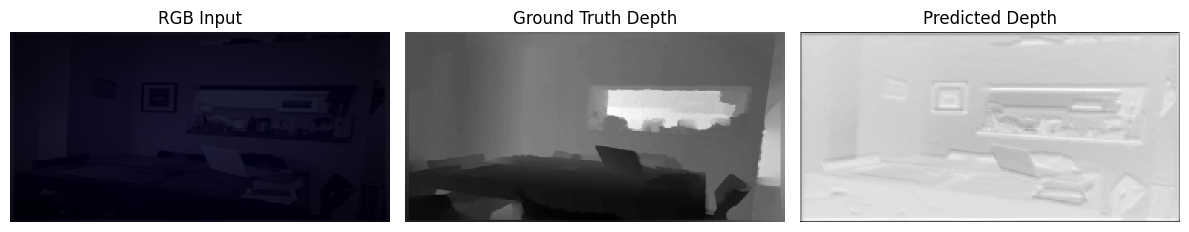

In [11]:
# # 0) Sanity check: print one parameter’s stats to confirm random init
# #    (mean ≃0, std≃~0.01–0.1 depending on init)
# for name, param in model.named_parameters():
#     print(f"{name:20s} | shape={tuple(param.shape):15s} | mean={param.mean():.4f}, std={param.std():.4f}")
#     break

# # 1) Evaluate on one batch before any training
# model.eval()
# with torch.no_grad():
#     imgs, gts = next(iter(dataloaders['train']))   # imgs: [B,3,H,W], gts: [B,1,H,W]
#     imgs, gts  = imgs.to(device), gts.to(device)

#     preds = model(imgs).cpu()                       # [B,1,H,W] on CPU now
#     gts   = gts.cpu()

#     # -- Batch L1 loss
#     batch_loss = Recons_loss(preds, gts)
#     print(f"Batch L1 loss before training:        {batch_loss.item():.4f}")

#     # -- Single‐sample L1 loss
#     pred0 = preds[0].unsqueeze(0)  # [1,1,H,W]
#     gt0   = gts[0].unsqueeze(0)
#     sample_loss = Recons_loss(pred0, gt0)
#     print(f"Single‐sample L1 loss before training: {sample_loss.item():.4f}")

# # 2) Visualize that first sample
# visualize_pair(imgs[0].cpu(), gts[0], preds[0])

# # CONFIRM THAT WEIGHTS ARE UNLOADED

def unnormalize(img_tensor):
    """
    img_tensor: torch.Tensor [3,H,W] with ImageNet normalization applied
    returns:     numpy array [H,W,3] in [0,1] for plt.imshow
    """
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    img = img_tensor * std + mean
    return img.permute(1,2,0).clamp(0,1).cpu().numpy()

def visualize_pair(rgb, gt_depth, pred_depth):
    """
    rgb:        torch.Tensor [3,H,W]
    gt_depth:   torch.Tensor [1,H,W]
    pred_depth: torch.Tensor [1,H,W]
    """
    rgb_np  = unnormalize(rgb)
    gt_np   = gt_depth.squeeze(0).cpu().numpy()
    pred_np = pred_depth.squeeze(0).cpu().numpy()

    fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(12,4))
    ax1.imshow(rgb_np)
    ax1.set_title("RGB Input")
    ax1.axis("off")

    ax2.imshow(gt_np, cmap="gray")
    ax2.set_title("Ground Truth Depth")
    ax2.axis("off")

    ax3.imshow(pred_np, cmap="gray")
    ax3.set_title("Predicted Depth")
    ax3.axis("off")

    plt.tight_layout()
    plt.show()
    
model.eval()
with torch.no_grad():
    imgs, gts = next(iter(dataloaders['train']))   # imgs: [B,3,H,W], gts: [B,1,H,W]
    imgs, gts  = imgs.to(device), gts.to(device)

    preds = model(imgs).cpu()                       # [B,1,H,W] on CPU now
    gts   = gts.cpu()

    # -- Batch L1 loss
    batch_loss = Recons_loss(preds, gts)
    print(f"Batch L1 loss before training:        {batch_loss.item():.4f}")

    # -- Single‐sample L1 loss
    pred0 = preds[0].unsqueeze(0)  # [1,1,H,W]
    gt0   = gts[0].unsqueeze(0)
    sample_loss = Recons_loss(pred0, gt0)
    print(f"Single‐sample L1 loss before training: {sample_loss.item():.4f}")

# 2) Visualize that first sample
visualize_pair(imgs[0].cpu(), gts[0], preds[0])


In [17]:
# Training loop
import matplotlib.pyplot as plt

# Training loop
num_epochs = 500
train_losses = []
val_losses = []
checkpoint = None
starting_epoch = 0

if os.path.exists('checkpoint_epoch.pth'):
    checkpoint = torch.load('checkpoint_epoch.pth', map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    train_losses = checkpoint['training_losses']
    val_losses = checkpoint['val_losses']
    starting_epoch = checkpoint['epoch']

print(f'Starting on epoch {starting_epoch}')
for epoch in range(starting_epoch, num_epochs):
    # Training phase
    model.train()  # Set the model to training mode
    running_train_loss = 0.0
    for inputs, labels in dataloaders['train']:
        # Forward pass
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = Recons_loss(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate the running loss
        running_train_loss += loss.item() * inputs.size(0)

    epoch_train_loss = running_train_loss / len(dataloaders['train'].dataset)
    train_losses.append(epoch_train_loss)

    # Validation phase
    model.eval()   # Set the model to evaluation mode
    running_val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            # Forward passs
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = Recons_loss(outputs, labels)

            # Calculate the running loss
            running_val_loss += loss.item() * inputs.size(0)

    epoch_val_loss = running_val_loss / len(dataloaders['test'].dataset)
    val_losses.append(epoch_val_loss)

    # Print the loss for every 100 epochs
    # print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}')
    if (epoch + 1) % 100 == 0:
        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}')

    # Save the trained model
    checkpoint = {
        'epoch': epoch+1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'training_losses': train_losses,
        'val_losses': val_losses,
    }
    torch.save(checkpoint, 'checkpoint_epoch.pth', _use_new_zipfile_serialization=False)

        
# # Save the trained model
# torch.save(model.state_dict(), 'Your_prediction_model.pth')

/local_scratch/slurm.2763921/ipykernel_4177820/2119949361.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('checkpoint_epoch.pth', map_location=d

Starting on epoch 116
Epoch 200/500, Train Loss: 0.0640, Val Loss: 0.0339
Epoch 300/500, Train Loss: 0.0636, Val Loss: 0.0342
Epoch 400/500, Train Loss: 0.0626, Val Loss: 0.0323
Epoch 500/500, Train Loss: 0.0608, Val Loss: 0.0333


## Visualize the Training Curve and Validation Results
Note: In this section, you need to visualize the Training curve in the training loop and print out the first 10 validation data in the order of: input image- prediction - groundtruth 

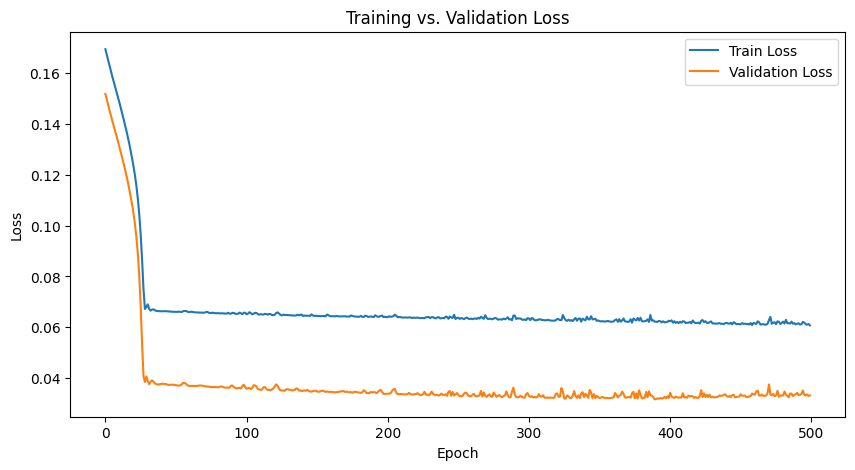

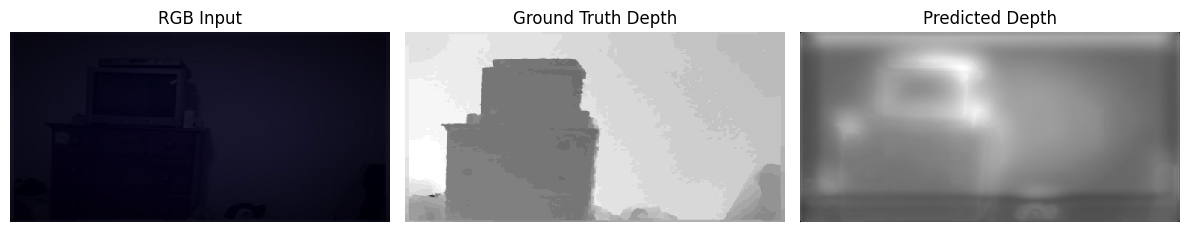

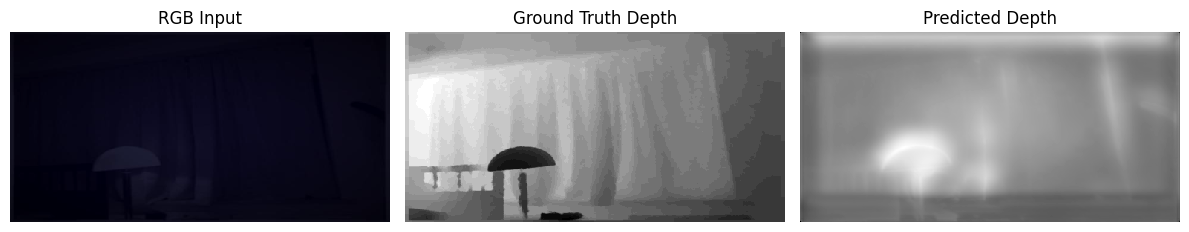

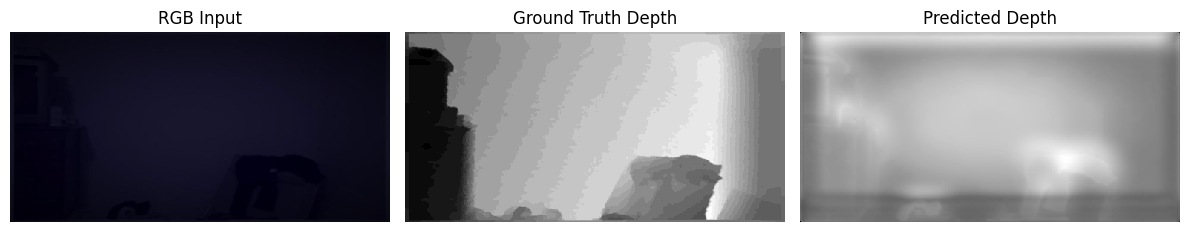

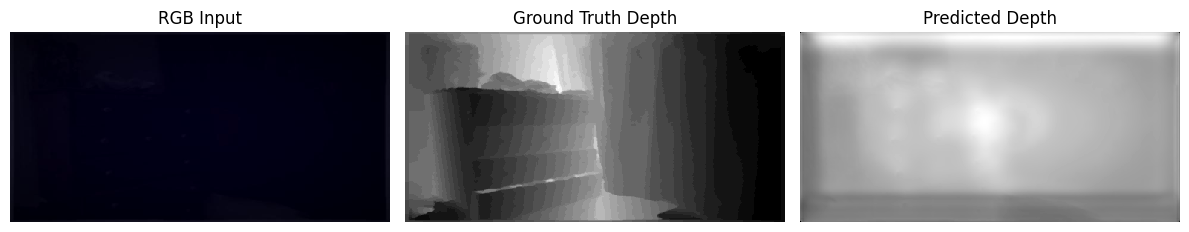

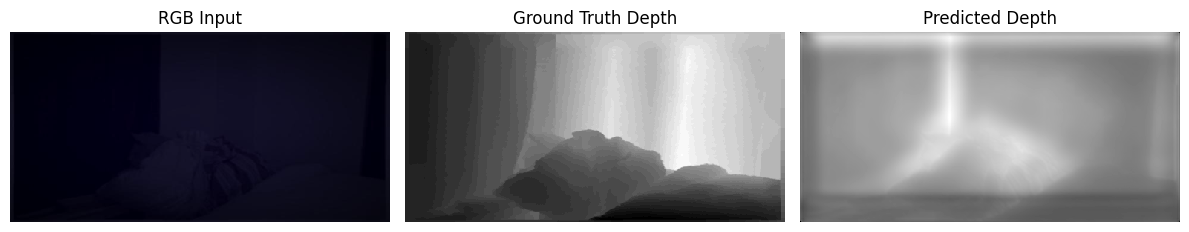

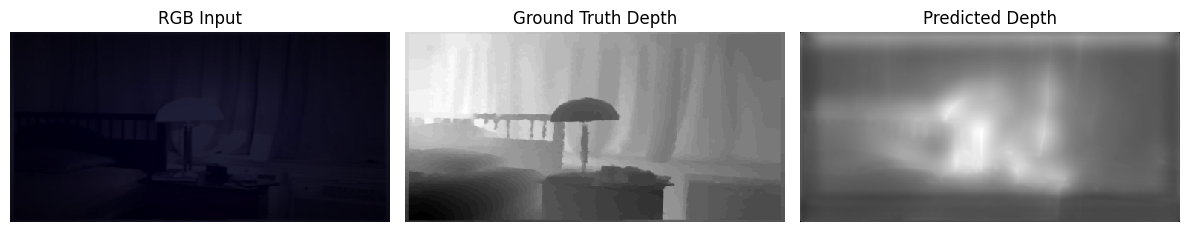

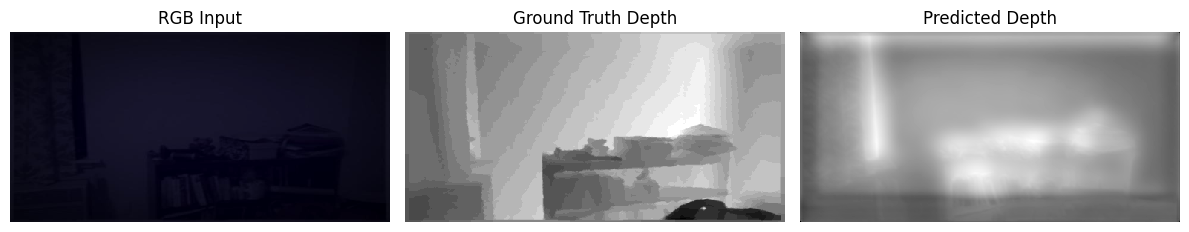

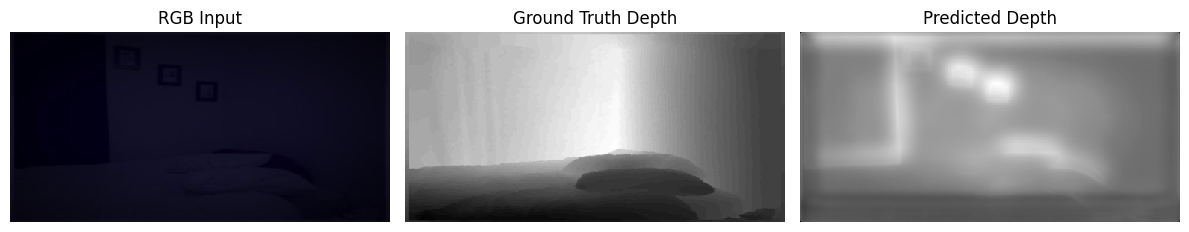

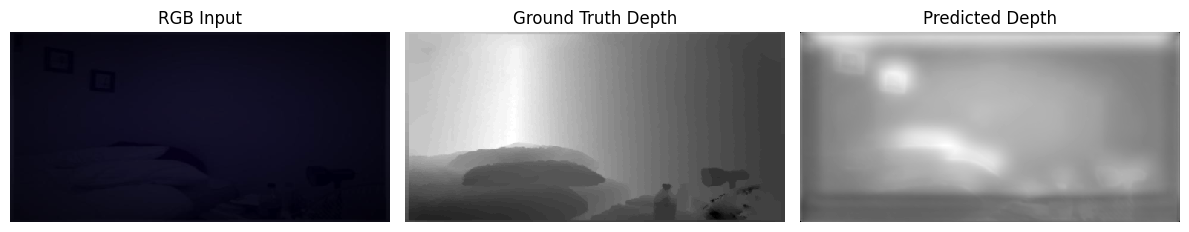

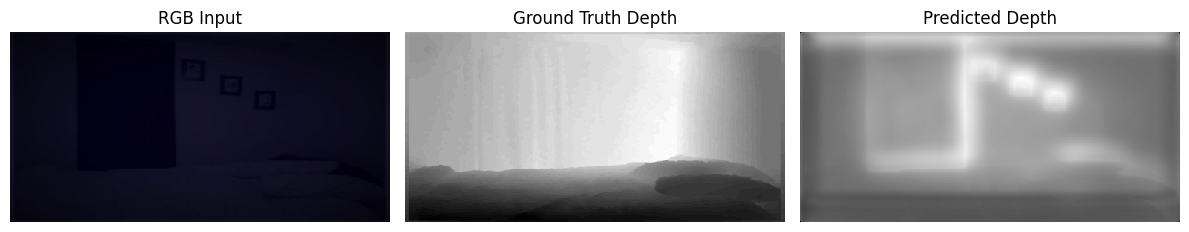

In [18]:
# Plot the validation results: input image-ouput depthmap - groundtruth depthmap
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses,   label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.show()

# 2) Visualize the first 10 validation samples
model.eval()
count = 0
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        # move to device & back to CPU after inference
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs).cpu()
        inputs  = inputs.cpu()
        labels  = labels.cpu()
        
        # loop through batch
        for i in range(inputs.size(0)):
            visualize_pair(
                inputs[i],    # RGB image [3,H,W]
                labels[i],    # ground‐truth depth [1,H,W]
                outputs[i]    # predicted depth [1,H,W]
            )
            count += 1
            if count >= 10:
                break
        if count >= 10:
            break